In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as linalg
import torch.distributions as tdist

import torch.optim as optim
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
class GMM(nn.Module):
    
    def __init__(self, D, K, cov_style="full", μs_init_min_and_max=None):
        
        super().__init__()
        
        self.K = K
        self.D = D
        self.cov_style = cov_style
        
        self.pre_π = nn.Parameter(torch.zeros(self.K, ))
        
        if μs_init_min_and_max is None:
            self.μs = nn.Parameter((torch.rand(self.K, self.D) - 0.5) * 2)
        else:
            μs_init_range = μs_init_min_and_max[1] - μs_init_min_and_max[0]
            self.μs = nn.Parameter(
                torch.rand(self.K, self.D) * μs_init_range.reshape(1, self.D) + μs_init_min_and_max[0].reshape(1, self.D)
            )
        
        if self.cov_style == "full":
            Σs_init = torch.eye(D).reshape(1, D, D).repeat(self.K, 1, 1)
            self.pre_Σs = nn.Parameter(linalg.cholesky(Σs_init, upper=True))
        elif self.cov_style == "diag":
            self.pre_Σs = torch.nn.Parameter(torch.rand(self.K, self.D))
        else:
            raise ValueError(f"{cov_style} is an invalid covariance style.")
            
    @property
    def π(self):
        return torch.softmax(self.pre_π, dim=0)
    
    @property
    def categorical(self):
        return tdist.Categorical(logits=self.pre_π)
    
    @property
    def Σs(self):
        if self.cov_style == "full":
            Ls = torch.triu(self.pre_Σs)
            return torch.bmm(Ls.transpose(1, 2), Ls)
        elif self.cov_style == "diag":
            # (K, D, 1) * (1, D, D) =(broadcast)=> (K, D, D) * (K, D, D) =(elementwise)=> (K, D, D)
            return (self.pre_Σs ** 2).unsqueeze(-1) * torch.eye(self.D).unsqueeze(0)
    
    @property
    def gaussians(self):
        return tdist.MultivariateNormal(self.μs, self.Σs)
        
    def log_prob(self, samples):
        
        # this function just implements the log probability of the gmm model in a numerically stable way
        
        N = samples.shape[0]
        log_π = F.log_softmax(self.pre_π, dim=0).reshape(1, -1)  # (1, K)
        log_probs_under_each_gaussian = self.gaussians.log_prob(samples.reshape(N, 1, self.D))  # (N, K)
        log_probs = torch.logsumexp(log_π + log_probs_under_each_gaussian, dim=1)
        
        return log_probs
    
    def sample(self, N):
        
        indices = self.categorical.sample((N, ))  # (N,)
        samples_from_each_gaussian = self.gaussians.rsample(sample_shape=(N, ))  # (n, K, D)
        
        # from pytorch doc for gather: out[i][j][k] = input[i][index[i][j][k]][k]
        # we know that we want samples to be of shape (N, D), so out should have shape (N, 1, D)
        
        samples = samples_from_each_gaussian.gather(
            dim=1,  # we will be indexing through the 1-th dimension (K)
            index=indices.reshape(-1, 1, 1).repeat(1, 1, self.D)
        ).squeeze()  # (N, D)
        
        return samples
    
    def compute_kl(self, log_unnorm_p, N_per_gaussian):

        # I was able to compute a stochastic estimate of KL using two tricks:
        # 1) bypass reparameterizing the categorical using marginalization (I don't want to use GumbelSoftmax)
        # 2) pathwise gradient through Gaussians through reparameterization
        
        samples = self.gaussians.rsample((N_per_gaussian, )).reshape(N_per_gaussian * self.K, self.D)
        kl = (self.π.repeat(N_per_gaussian) * (self.log_prob(samples) - log_unnorm_p(samples))).sum() / N_per_gaussian
        
        return kl

In [25]:
def w1(z): return torch.sin(2 * torch.pi * z[:, 0] / 4)                 
def w2(z): return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.5) ** 2)
def σ(x): return 1 / (1 + torch.exp(-x))
def w3(z): return 3 * σ((z[:, 0] - 1) / 0.3)

In [121]:
def safe_log(x):
    return torch.log(x + 1e-5)

def U1(z):
    part_1 = (1 / 2) * ((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2
    part_2 = safe_log(
        torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) +
        torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2)
    )
    return part_1 - part_2

def taper(z):
    return torch.sigmoid(
        ( 5 - torch.linalg.vector_norm(z, dim=1, ord=np.inf) ) * 10
    )

def add_taper(potential):
    def new_potential(z):
        # so density is exp(-potential(z) + log(taper(z))) = exp(-potential(z)) * taper(z)
        return potential(z) - safe_log(taper(z))
    return new_potential

@add_taper
def U2(z):
    return ((1/2) * ((z[:,1] - w1(z)) / 0.4) ** 2)

@add_taper
def U3(z):
    return - safe_log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    )

@add_taper
def U4(z):
    return - safe_log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.34) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    )

def U_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = safe_log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2)
    )
    return (term1 - term2)
def U8(z, divider=1):
    return U_with_argument(z, torch.pi/4, 3) + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) + \
           U_with_argument(z, 0, 3) + \
           U_with_argument(z, torch.pi / 2, 3)

In [188]:
potential_func = "U4"
U = eval(potential_func)

In [189]:
xs = torch.linspace(-6, 6, 100)
ys = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, ys)
xxs_flat, yys_flat = xxs.reshape(-1, 1), yys.reshape(-1, 1)
grid = torch.hstack([xxs_flat, yys_flat])

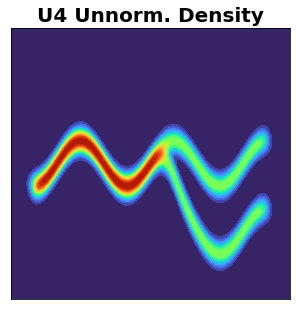

In [190]:
plt.figure(figsize=(5, 5))

plt.contourf(
    xxs.numpy(), yys.numpy(), torch.exp(-U(grid).reshape(100, 100)),
    levels=20, cmap="turbo"
)

plt.xticks([])
plt.yticks([])

plt.title(f"{potential_func} Unnorm. Density", fontsize=20, fontweight="bold")

plt.savefig(f"2d_data/{potential_func}_unnorm_density.png", dpi=300, bbox_inches="tight")

In [ ]:
torch.manual_seed(42)

K = 50

q = GMM(
    D=2,
    K=K,
    μs_init_min_and_max=torch.tensor([
        [-6., -6.],
        [6., 6.]]
    )
)
opt = optim.Adam(q.parameters(), lr=1e-2)

μs_init = q.μs.detach().numpy().copy()
N = 1000
N_per_gaussian = math.ceil(N / K)

sample_kls = []

for i in range(1, 10001):

    sample_kl = q.compute_kl(log_unnorm_p=lambda x: -U(x), N_per_gaussian=N_per_gaussian)

    sample_kls.append(float(sample_kl))

    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 1000 == 0:
        print("Iteration:", i, " KL:", sum(sample_kls[-30:]) / 30)

Iteration: 1000  KL: -2.805839109420776
Iteration: 2000  KL: -2.8345176537831622
Iteration: 3000  KL: -2.837516681353251
Iteration: 4000  KL: -2.837480966250102
Iteration: 5000  KL: -2.838671414057414
Iteration: 6000  KL: -2.8414256731669107
Iteration: 7000  KL: -2.840571729342143
Iteration: 8000  KL: -2.843117658297221
Iteration: 9000  KL: -2.8414400100708006


In [ ]:
torch.manual_seed(42)
with torch.no_grad():
    samples = q.sample(11000).numpy()

In [ ]:
np.save(f"2d_data/{potential_func}_gmm_samples.npy", samples)

In [ ]:
data = np.load(f"2d_data/{potential_func}_gmm_samples.npy")

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(samples[:, 0], samples[:, 1], s=0.1, color="black")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xticks([])
plt.yticks([])
plt.title(f"{potential_func} GMM Samples", fontsize=20, fontweight="bold")
plt.savefig(f"2d_data/{potential_func}_gmm_samples.png", dpi=300, bbox_inches="tight")

In [ ]:
with torch.no_grad():
    probs = q.log_prob(grid).exp().numpy()

In [ ]:
plt.figure(figsize=(5, 5))

plt.contourf(
    xxs.numpy(), yys.numpy(), probs.reshape(100, 100),
    levels=20, cmap="turbo"
)

plt.xticks([])
plt.yticks([])

plt.title(f"{potential_func} GMM Density", fontsize=20, fontweight="bold")
plt.savefig(f"2d_data/{potential_func}_gmm_density.png", dpi=300, bbox_inches="tight")

In [133]:
# how do you stack a mixture of Gaussians for every dimension of the output?
# does the linear layer used to create means count as an extra layer?? (yes or no)
# this can be critical

# output shape: (bs, H)

# required means: (bs, H, C), required weight (bs, H) @ (H, D, C) => (bs, D, C)
# required logvars: (bs, H, C)
# required mixing coeffs: (bs, H, C)

# weight 

In [ ]:
()

In [130]:
q_1d = GMM(D=1, K=10)

opt = optim.Adam(q_1d.parameters(), lr=1e-3)

for i in range(1, 10001):

    loss = - q_1d.log_prob(torch.tensor(samples[:, 0])).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if (i) % 1000 == 0:
    
        print(loss)

tensor(1.3070, grad_fn=<NegBackward0>)
tensor(1.2789, grad_fn=<NegBackward0>)
tensor(1.2746, grad_fn=<NegBackward0>)
tensor(1.2735, grad_fn=<NegBackward0>)
tensor(1.2730, grad_fn=<NegBackward0>)
tensor(1.2729, grad_fn=<NegBackward0>)
tensor(1.2728, grad_fn=<NegBackward0>)
tensor(1.2727, grad_fn=<NegBackward0>)
tensor(1.2727, grad_fn=<NegBackward0>)
tensor(1.2727, grad_fn=<NegBackward0>)


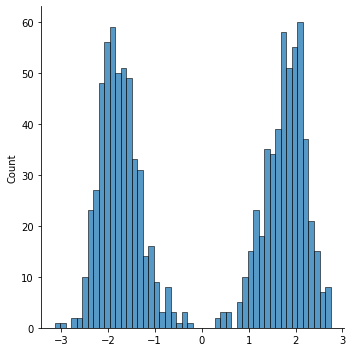

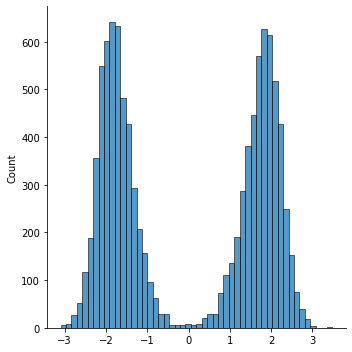

In [131]:
with torch.no_grad():
    samples_1d = q_1d.sample(1000).numpy()
sns.displot(samples_1d, bins=50)
sns.displot(samples[:, 0], bins=50)
plt.show()